In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.linalg import norm
from IPython.display import clear_output
from IPython.utils import io
import random
from copy import deepcopy
from urllib import request
import tempfile
import gzip
from ast import literal_eval

from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# from polara.lib.tensor import hooi
# from polara.lib.sparse import tensor_outer_at

from dataprep import transform_indices, full_preproccessing
from utils import topn_recommendations, downvote_seen_items, make_prediction, model_evaluate
# from RecVAE.utils import *
# from RecVAE.model import VAE as RecVAE

In [2]:
def fix_torch_seed(seed, conv_determinism=True):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # settings below may affect computational performance
    # see https://pytorch.org/docs/stable/notes/randomness.html:
    if conv_determinism:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def set_random_seed(seed):
#     torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
# fix_torch_seed(42)
set_random_seed(42)

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data preprocessing

In [5]:
# def amazon_data_reader(path):
#     with gzip.open(path, 'rt') as gz:
#         for line in gz:
#             yield literal_eval(line)

# def read_amazon_data(path=None, name=None):
#     '''Data is taken from https://jmcauley.ucsd.edu/data/amazon/'''
#     if path is None and name is None:
#             raise ValueError('Either the name of the dataset to download \
#                 or a path to a local file must be specified.')
#     if path is None:
#         file_url = f'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_{name}_5.json.gz'
#         print(f'Downloading data from: {file_url}')
#         with request.urlopen(file_url) as response:
#             file = response.read()
#             with tempfile.NamedTemporaryFile(delete=False) as temp:
#                 temp.write(file)
#                 path = temp.name
#                 print(f'Temporarily saved file at: {path}')
#     data = pd.DataFrame.from_records(
#         amazon_data_reader(path),
#         columns=['reviewerID', 'asin', 'overall', 'unixReviewTime']
#     )
#     data.to_csv(f'Amazon_{name}.csv', index=None)
#     return data

# data = read_amazon_data(name = "Video_Games")
# data.rename(columns = {'reviewerID' : 'userid', 'asin' : 'movieid', "overall" : "rating", "unixReviewTime" : "timestamp"}, inplace = True)

In [6]:
data = pd.read_csv('Amazon_Video_Games.csv')
data.rename(columns = {'reviewerID' : 'userid', 'asin' : 'movieid', "overall" : "rating", "unixReviewTime" : "timestamp"}, inplace = True)

In [7]:
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)

There are 24303 users
Filtered 17693 invalid observations.


In [8]:
del data

In [9]:
# alpha = 4
# a = training[training['rating']>=alpha][['userid', 'movieid']]
# a.columns = ['uid', 'sid']
# a.to_csv("train.csv", index=None)
# b = testset_valid[(testset_valid['rating']>=alpha)&(testset_valid['movieid'].isin(training['movieid']))][['userid', 'movieid']]
# b.columns = ['uid', 'sid']
# b.to_csv("validation_tr.csv", index=None)
# c = holdout_valid[(holdout_valid['rating']>=alpha)&(holdout_valid['movieid'].isin(training['movieid']))&(holdout_valid['userid'].isin(testset_valid['userid']))][['userid', 'movieid']]
# c.columns = ['uid', 'sid']
# c.to_csv("validation_te.csv", index=None)
# d = testset[(testset['rating']>=alpha)&(testset['movieid'].isin(training['movieid']))][['userid', 'movieid']]
# d.columns = ['uid', 'sid']
# d.to_csv("test_tr.csv", index=None)
# e = holdout[(holdout['rating']>=alpha)&(holdout['movieid'].isin(training['movieid']))&(holdout['userid'].isin(testset['userid']))][['userid', 'movieid']]
# e.columns = ['uid', 'sid']
# e.to_csv("test_te.csv", index=None)

# Baselines

## TopPop

In [7]:
def build_popularity_model(trainset, trainset_description):
    itemid = trainset_description['items']
    item_popularity = trainset[itemid].value_counts()
    return item_popularity

def popularity_model_scoring(params, testset, testset_description):
    item_popularity = params
    n_items = item_popularity.index.max() + 1
    n_users = testset_description['n_test_users']
    # fill in popularity scores for each item with indices from 0 to n_items-1
    popularity_scores = np.zeros(n_items,)
    popularity_scores[item_popularity.index] = item_popularity.values
    # same scores for each test user
    scores = np.tile(popularity_scores, n_users).reshape(n_users, n_items)
    return scores

## Normalized PureSVD

In [16]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), shape=(useridx.values.max() + 1, data_description["n_items"]), dtype='f8')

def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    #print(source_matrix.shape)
    D = norm(source_matrix, axis=0)
    A = source_matrix.dot(diags(D**(config['f']-1)))
    _, _, vt = svds(A, k=config['rank'], return_singular_vectors='vh')
#     singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors

def svd_model_scoring(params, data, data_description):
    item_factors = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    #print(test_matrix.shape, item_factors.shape)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

## EASEr

In [8]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), shape=(useridx.values.max() + 1, data_description["n_items"]), dtype='f8')

def easer(data, data_description, lmbda=500):
    X = matrix_from_observations(data, data_description)
    G = X.T.dot(X)
    diag_indices = np.diag_indices(G.shape[0])
    G[diag_indices] += lmbda
    P = np.linalg.inv(G.A)
    B = P / (-np.diag(P))
    B[diag_indices] = 0
    
    return B

def easer_scoring(params, data, data_description):
    item_factors = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    scores = test_matrix.dot(item_factors)
    return scores

## CoFFee

In [8]:
def tf_model_build(config, data, data_description):
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    idx = data[[userid, itemid, feedback]].values
    idx[:, -1] = idx[:, -1] - data_description['min_rating'] # works only for integer ratings!
    val = np.ones(idx.shape[0], dtype='f8')
    
    n_users = data_description["n_users"]
    n_items = data_description["n_items"]
    n_ratings = data_description["n_ratings"]
    shape = (n_users, n_items, n_ratings)
    core_shape = config['mlrank']
    num_iters = config["num_iters"]
    
    u0, u1, u2, g = hooi(
        idx, val, shape, core_shape,
        num_iters=num_iters,
        parallel_ttm=False, growth_tol=0.01,
    )
    return u0, u1, u2
        

def tf_scoring(params, data, data_description):
    user_factors, item_factors, feedback_factors = params
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    data = data.sort_values(userid)
    useridx = data[userid].values
    itemidx = data[itemid].values
    ratings = data[feedback].values
    ratings = ratings - data_description['min_rating'] # works only for integer ratings!
    
    tensor_outer = tensor_outer_at('cpu')
    # use the fact that test data is sorted by users for reduction:
    scores = tensor_outer(
        1.0,
        item_factors,
        feedback_factors,
        itemidx,
        ratings
    )
    scores = np.add.reduceat(scores, np.r_[0, np.where(np.diff(useridx))[0]+1])
    scores = np.tensordot(
        scores,
        feedback_factors[-1, :],
        axes=(2, 0)
    ).dot(item_factors.T)
    return scores

## Simple AE

In [10]:
class SimpleDataset(Dataset):
    def __init__(self, data, augment=False):
        self.data = data
        self.augment = augment

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.augment:
            num_noise = np.random.randint(0, int(0.1*self.data.shape[1]))
            idxs = torch.randint(0, self.data.shape[1], size=(num_noise,))
            noised_input = self.data[idx].detach().clone().to_dense()
            noised_input[idxs] = torch.distributions.bernoulli.Bernoulli(0.5).sample(sample_shape=(num_noise,))
            
            useridx = np.zeros_like(noised_input)
            itemidx = np.arange(self.data.shape[1])
            noised_input = torch.sparse_coo_tensor(np.array([itemidx,]), noised_input,
                                                   size=torch.Size((data_description["n_items"],)), dtype=torch.float32)
            return noised_input, self.data[idx]
        else:
            return self.data[idx], self.data[idx]

In [11]:
class baseAE(nn.Module):
    def __init__(self, n_items, hid):
        super(baseAE, self).__init__()
        self.V = nn.Linear(n_items, hid)
        self.VT = nn.Linear(hid, n_items)
        self.relu = nn.ReLU()

    def forward(self, x):
        # encode
        x = self.V(x)
        x = self.relu(x)
        # decode
        output = self.VT(x)
#         output = self.relu(output)
        return output

## RecVAE

In [7]:
vae = RecVAE(600, 200, 1000)
sum(p.numel() for p in vae.parameters() if p.requires_grad)

2490400

# Tuning

## Normalized PureSVD

In [14]:
rank_grid = []
for i in range(5, 10):
    rank_grid.append(2 * 2 ** i)
    rank_grid.append(3 * 2 ** i)
    
rank_grid = np.array(rank_grid)

f_grid = np.linspace(0, 2, 21)

In [17]:
hr_tf = {}
mrr_tf = {}
grid = list(zip(np.meshgrid(rank_grid, f_grid)[0].flatten(), np.meshgrid(rank_grid, f_grid)[1].flatten()))
for params in tqdm(grid):
    r, f = params
    svd_config = {'rank': int(r), 'f': f}
    svd_params = build_svd_model(svd_config, training, data_description)
    svd_scores = svd_model_scoring(svd_params, testset_valid, data_description)
    downvote_seen_items(svd_scores, testset_valid, data_description)
    svd_recs = topn_recommendations(svd_scores, topn=10)
    hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(svd_recs, holdout_valid, data_description)
    hr_tf[f'r={r}, f={f:.2f}'] = hr
    mrr_tf[f'r={r}, f={f:.2f}'] = mrr

  0%|          | 0/210 [00:00<?, ?it/s]

MemoryError: Unable to allocate 903. KiB for an array with shape (115526,) and data type float64

## EASEr

In [9]:
lambda_grid = np.arange(10, 510, 10)

In [10]:
hr_tf = {}
mrr_tf = {}
for lmbda in tqdm(lambda_grid):
    easer_params = easer(training, data_description, lmbda=lmbda)
    easer_scores = easer_scoring(easer_params, testset_valid, data_description)
    downvote_seen_items(easer_scores, testset_valid, data_description)
    easer_recs = topn_recommendations(easer_scores, topn=10)
    hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(easer_recs, holdout_valid, data_description)
    hr_tf[lmbda] = hr
    mrr_tf[lmbda] = mrr

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
{k: v for k, v in sorted(hr_tf.items(), key=lambda item: item[1])}

{10: 0.06382978723404255,
 20: 0.06758448060075094,
 30: 0.07108886107634543,
 40: 0.07459324155193993,
 50: 0.07659574468085106,
 60: 0.07909887359198998,
 80: 0.08035043804755945,
 70: 0.08110137672090113,
 90: 0.08110137672090113,
 110: 0.08110137672090113,
 100: 0.08160200250312892,
 120: 0.0818523153942428,
 130: 0.08235294117647059,
 140: 0.08260325406758448,
 150: 0.08310387984981227,
 160: 0.08310387984981227,
 170: 0.08385481852315395,
 180: 0.08485607008760951,
 190: 0.0853566958698373,
 200: 0.08610763454317898,
 210: 0.08660826032540676,
 220: 0.08685857321652066,
 350: 0.08710888610763455,
 360: 0.08710888610763455,
 370: 0.08710888610763455,
 280: 0.08735919899874844,
 290: 0.08735919899874844,
 340: 0.08735919899874844,
 390: 0.08735919899874844,
 260: 0.08760951188986234,
 270: 0.08760951188986234,
 320: 0.08760951188986234,
 330: 0.08760951188986234,
 380: 0.08760951188986234,
 240: 0.08785982478097622,
 250: 0.08785982478097622,
 300: 0.08785982478097622,
 400: 0.0878

## CoFFee

In [13]:
config = {
    "scaling": 1,
    "n_ratings": data_description['n_ratings'],
    "num_iters": 4,
    "params": None,
    "randomized": True,
    "growth_tol": 1e-4,
    "seed": 42
}

grid1 = 2**np.arange(4, 12)
grid2 = np.arange(2, 5)
grid = np.meshgrid(grid1, grid2)

In [12]:
hr_tf = {}
mrr_tf = {}
for r12, r3 in tqdm(zip(grid[0].flatten(), grid[1].flatten()), total=24):
    config['mlrank'] = (r12, r12, r3)
    tf_params = tf_model_build(config, training, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(tf_recs, holdout_valid, data_description)
    hr_tf[(r12, r3)] = hr
    mrr_tf[(r12, r3)] = mrr

  0%|          | 0/24 [00:00<?, ?it/s]

growth of the core: 1.0
growth of the core: 0.17108376145578136
growth of the core: 0.013724276626127477
growth of the core: 0.002121752668025982
Done
growth of the core: 1.0
growth of the core: 0.1944648491989059
growth of the core: 0.02467704747273349
growth of the core: 0.005981755700370528
Done
growth of the core: 1.0
growth of the core: 0.16282144181882102
growth of the core: 0.029912952116613767
growth of the core: 0.013916498704220537
Done
growth of the core: 1.0
growth of the core: 0.23035313236669488
growth of the core: 0.034784826568450604
growth of the core: 0.011006067169166954
Done
growth of the core: 1.0
growth of the core: 0.17594728189169354
growth of the core: 0.030919135038606764
growth of the core: 0.008959802437981649
Done
growth of the core: 1.0
growth of the core: 0.1619910003475919
growth of the core: 0.025820893734533307
growth of the core: 0.008684790230411127
Done
growth of the core: 1.0
growth of the core: 0.19297251628357556
growth of the core: 0.01668695007

In [13]:
hr_tf

{(16, 2): 0.05102639296187683,
 (32, 2): 0.05689149560117302,
 (64, 2): 0.06099706744868035,
 (128, 2): 0.05337243401759531,
 (256, 2): 0.06862170087976541,
 (512, 2): 0.031085043988269796,
 (1024, 2): 0.021114369501466276,
 (2048, 2): 0.008211143695014663,
 (16, 3): 0.04868035190615835,
 (32, 3): 0.04574780058651026,
 (64, 3): 0.052785923753665684,
 (128, 3): 0.047507331378299114,
 (256, 3): 0.04105571847507332,
 (512, 3): 0.03284457478005865,
 (1024, 3): 0.01818181818181818,
 (2048, 3): 0.004105571847507331,
 (16, 4): 0.04281524926686217,
 (32, 4): 0.04574780058651026,
 (64, 4): 0.04926686217008798,
 (128, 4): 0.0469208211143695,
 (256, 4): 0.0404692082111437,
 (512, 4): 0.03167155425219941,
 (1024, 4): 0.01935483870967742,
 (2048, 4): 0.004105571847507331}

## Simple AE

In [12]:
useridx = training[data_description['users']].values
itemidx = training[data_description['items']].values
# feedbackidx = training[data_description['feedback']].values
values = np.ones(len(itemidx))

In [13]:
user_tensor_train = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32)

In [19]:
train_dataset = SimpleDataset(user_tensor_train, augment=True)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [20]:
grid = 2**np.arange(2, 11)

In [ ]:
params = []
histories = []
test_losses = []
mrrs = []
hrs = []
cs = []
early_stop = 10
n_epochs = 1000


for h in tqdm(grid):
    print('Hidden sizes:', h)
    
    bae = baseAE(data_description['n_items'], h).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(bae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    params.append(sum(p.numel() for p in bae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []
#     prev_train_loss = [1000]
    prev_test_loss = [1000]
    train_loss = 0.1 * len(train_dataloader)
    epoch = 1
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0
        for user_matrix in train_dataloader:
            optimizer.zero_grad()

            input_tensor, target = user_matrix
            input_tensor, target = input_tensor.to_dense().to(device), target.to_dense().to(device)

            output = bae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        tr_loss = train_loss / len(train_dataloader)
        history.append(tr_loss)

    #     print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))
        test_loss = 0
        with torch.no_grad():
            for user in testset.userid.unique():
                itemidx = testset.loc[testset.userid == user, data_description['items']].values
                values = np.ones(len(itemidx), dtype=np.float32)

                user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                          size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
                target = user_tensor_test.clone()

                output = bae(user_tensor_test)
                target.require_grad = False

                loss = criterion(output, target)
                test_loss += loss.data.item()

            test_losses.append(test_loss / testset.userid.nunique())
        val_loss = test_loss / testset.userid.nunique()
        val_history.append(val_loss)
        
        if prev_test_loss[-1] > val_loss:
            prev_test_loss = [val_loss]
            torch.save(bae.state_dict(), f'best_bae_{h}.pt')
        else:
            prev_test_loss.append(val_loss)
        
        stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_test_loss) == early_stop:
            print(f'Current epoch {epoch}. Best model found at epoch {stop}')
            break
        
        # only for this weird model (where dev loss increases)
#         if prev_train_loss[-1] > tr_loss:
#             prev_train_loss = [tr_loss]
#             torch.save(bae.state_dict(), f'best_bae_{h}.pt')
#         else:
#             prev_train_loss.append(tr_loss)
        
#         stop = epoch if epoch < early_stop else epoch-early_stop
#         if len(prev_train_loss) == early_stop:
#             print(f'Current epoch {epoch}. Best model found at epoch {stop}')
#             break
            
        epoch += 1
    
    # Testing the AE
    test_loss = 0
    scores = torch.zeros((len(testset_valid.userid.unique()), data_description['n_items']))
    model = baseAE(data_description['n_items'], h).to(device)
    model.load_state_dict(torch.load(f'best_bae_{h}.pt'))

    for i, user in enumerate(testset_valid.userid.unique()):
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
        target = user_tensor_test.clone()

        output = model(user_tensor_test)
        scores[i] = output[0].T
        target.require_grad = False

        loss = criterion(output, target)
        test_loss += loss.data.item()
    
    scores = scores.detach().numpy()        
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    print('Epochs:', stop)
    downvote_seen_items(scores, testset_valid, data_description)
    mrr10, hr10, c10 = make_prediction(scores, holdout_valid, data_description)
    mrrs.append(mrr10)
    hrs.append(hr10)
    cs.append(c10)
    
    print()
    print()

  0%|          | 0/9 [00:00<?, ?it/s]

Hidden sizes: 4


  0%|          | 0/9 [00:00<?, ?it/s]

Hidden sizes: 4
Current epoch 93. Best model found at epoch 83


C:\Users\Liza\AppData\Local\Temp\ipykernel_10488\1356720059.py:110: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  scores[i] = output[0].T


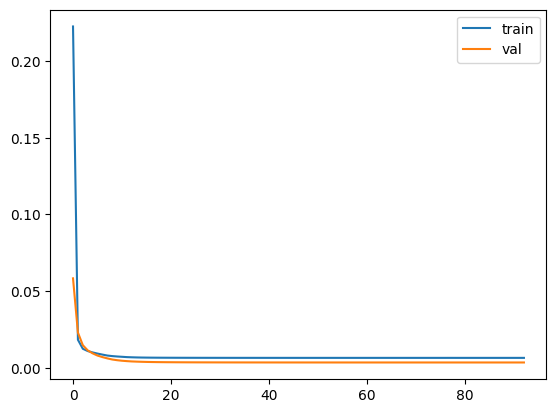

Test loss: 0.003412516100566204
Train loss: 0.006416392074682878
Epochs: 83


,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.00776,0.004139,0.002322,0.007509,0.00025,0.003888,0.00025,0.016976


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.010013,0.004416,0.00424,0.009762,0.00025,0.004165,0.00025,0.021907


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.021527,0.005183,0.006865,0.021277,0.00025,0.004932,0.00025,0.039381




Hidden sizes: 8
Current epoch 94. Best model found at epoch 84


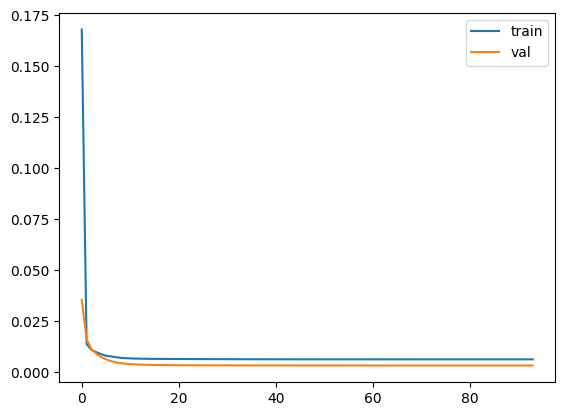

Test loss: 0.0033150711042217013
Train loss: 0.006321344437487287
Epochs: 84


,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.00801,0.005544,0.006259,0.00776,0.00025,0.005419,0.000125,0.017572


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.012265,0.006081,0.008884,0.012015,0.00025,0.005956,0.000125,0.026098


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.024531,0.006916,0.013123,0.023529,0.001001,0.006738,0.000178,0.025603




Hidden sizes: 16
Current epoch 97. Best model found at epoch 87


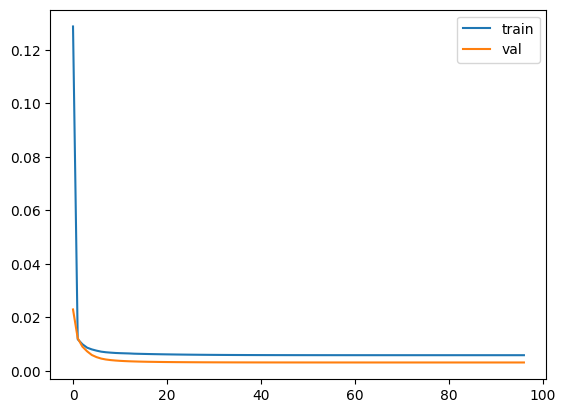

Test loss: 0.003118508913807777
Train loss: 0.005840880439853248
Epochs: 87


,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.012516,0.005549,0.009691,0.012015,0.000501,0.005298,0.00025,0.018504


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.022028,0.006771,0.013628,0.021277,0.000751,0.006485,0.000286,0.027829


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.03204,0.007433,0.022108,0.029787,0.002253,0.007046,0.000387,0.010244




Hidden sizes: 32
Current epoch 99. Best model found at epoch 89


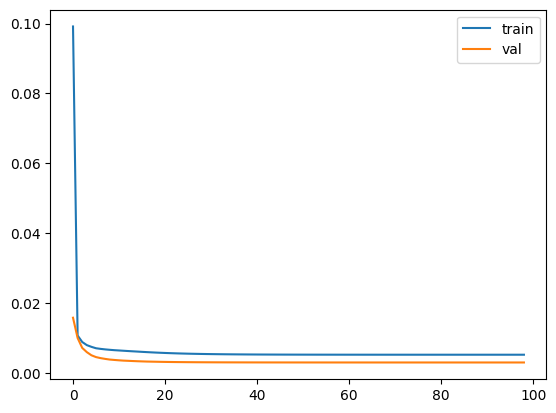

Test loss: 0.002923179816558847
Train loss: 0.005146038096131053
Epochs: 89


,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.017272,0.008544,0.022915,0.01627,0.001001,0.008235,0.000309,0.013297


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.027534,0.009907,0.03301,0.025782,0.001752,0.009485,0.000422,0.013479


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.049061,0.011398,0.049263,0.046058,0.003004,0.010873,0.000524,0.020148




Hidden sizes: 64
Current epoch 107. Best model found at epoch 97


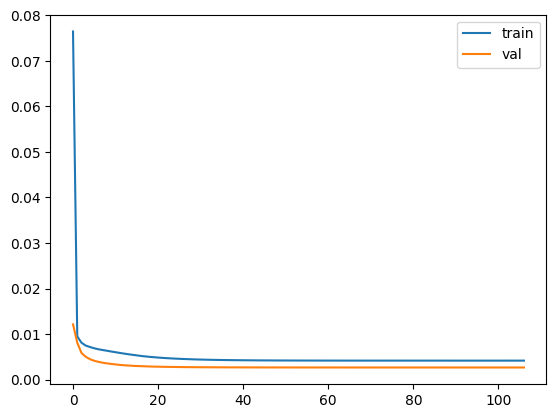

Test loss: 0.0026682072219593404
Train loss: 0.004173165675250412
Epochs: 97


,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.030788,0.018014,0.055219,0.029537,0.001252,0.017222,0.000793,0.028881


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.045557,0.019932,0.079043,0.042804,0.002753,0.018925,0.001006,0.019991


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.075344,0.022001,0.110943,0.069837,0.005507,0.020809,0.001193,0.013247




Hidden sizes: 128
Current epoch 184. Best model found at epoch 174


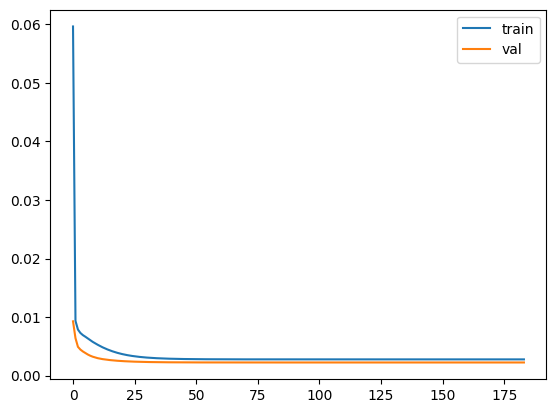

Test loss: 0.002250940249000086
Train loss: 0.0027797605559730025
Epochs: 174


,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.043554,0.022336,0.123864,0.041302,0.002253,0.021381,0.000955,0.026156


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.065582,0.025227,0.168686,0.062578,0.003004,0.024184,0.001043,0.038065


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.098373,0.027421,0.227842,0.092365,0.006008,0.026177,0.001244,0.029483




Hidden sizes: 256
Current epoch 182. Best model found at epoch 172


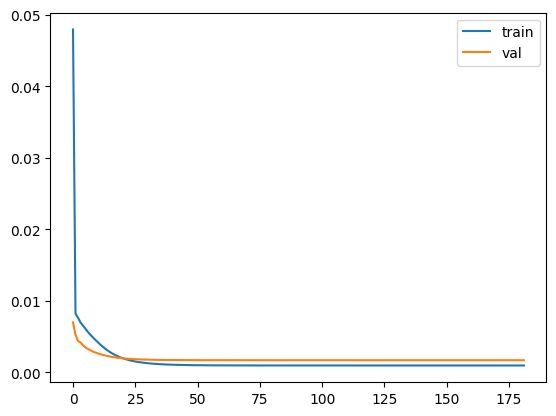

Test loss: 0.0017146291658143161
Train loss: 0.0009789559628756747
Epochs: 172


,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.045056,0.024543,0.265899,0.043054,0.002003,0.023838,0.000705,0.032261


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.069337,0.027761,0.352413,0.065081,0.004255,0.026786,0.000975,0.024068


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.097622,0.029686,0.460731,0.090864,0.006758,0.028565,0.001122,0.019788




Hidden sizes: 512
Current epoch 31. Best model found at epoch 21


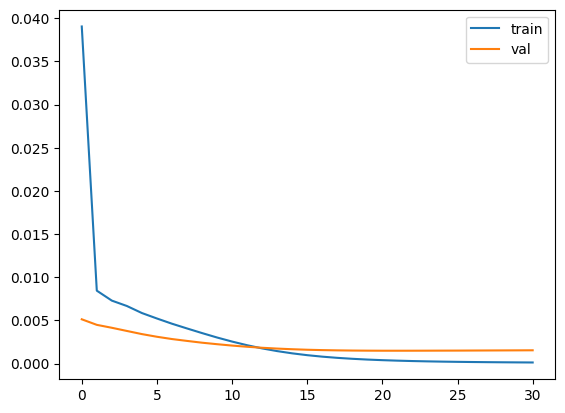

Test loss: 0.001499646365153538
Train loss: 0.00034960565487667466
Epochs: 21


,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.041302,0.024401,0.370483,0.04005,0.001252,0.023642,0.000759,0.04129


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.060075,0.026958,0.497173,0.057322,0.002753,0.025983,0.000975,0.036296


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.087359,0.028836,0.628609,0.083354,0.004005,0.027777,0.001059,0.044405




Hidden sizes: 1024
Current epoch 23. Best model found at epoch 13


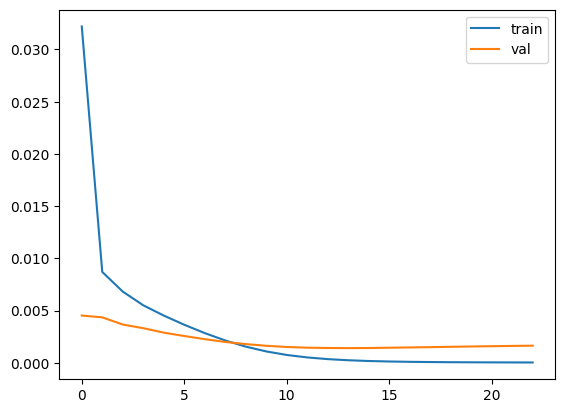

Test loss: 0.0013998409492646008
Train loss: 0.00023737902735585724
Epochs: 13


,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.039299,0.02315,0.38189,0.037797,0.001502,0.022716,0.000434,0.034529


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.059574,0.025758,0.514537,0.057071,0.002503,0.025188,0.00057,0.039559


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.08811,0.027722,0.647486,0.082854,0.005257,0.026965,0.000758,0.029307


In [18]:
params = []
histories = []
test_losses = []
mrrs = []
hrs = []
cs = []
early_stop = 10
n_epochs = 1000


for h in tqdm(grid):
    print('Hidden sizes:', h)
    
    bae = baseAE(data_description['n_items'], h).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(bae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    params.append(sum(p.numel() for p in bae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []
#     prev_train_loss = [1000]
    prev_test_loss = [1000]
    train_loss = 0.1 * len(train_dataloader)
    epoch = 1
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0
        for user_matrix in train_dataloader:
            optimizer.zero_grad()

            input_tensor, target = user_matrix
            input_tensor, target = input_tensor.to_dense().to(device), target.to_dense().to(device)

            output = bae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        tr_loss = train_loss / len(train_dataloader)
        history.append(tr_loss)

    #     print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))
        test_loss = 0
        with torch.no_grad():
            for user in testset.userid.unique():
                itemidx = testset.loc[testset.userid == user, data_description['items']].values
                values = np.ones(len(itemidx), dtype=np.float32)

                user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                          size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
                target = user_tensor_test.clone()

                output = bae(user_tensor_test)
                target.require_grad = False

                loss = criterion(output, target)
                test_loss += loss.data.item()

            test_losses.append(test_loss / testset.userid.nunique())
        val_loss = test_loss / testset.userid.nunique()
        val_history.append(val_loss)
        
        if prev_test_loss[-1] > val_loss:
            prev_test_loss = [val_loss]
            torch.save(bae.state_dict(), f'best_bae_{h}.pt')
        else:
            prev_test_loss.append(val_loss)
        
        stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_test_loss) == early_stop:
            print(f'Current epoch {epoch}. Best model found at epoch {stop}')
            break
        
        # only for this weird model (where dev loss increases)
#         if prev_train_loss[-1] > tr_loss:
#             prev_train_loss = [tr_loss]
#             torch.save(bae.state_dict(), f'best_bae_{h}.pt')
#         else:
#             prev_train_loss.append(tr_loss)
        
#         stop = epoch if epoch < early_stop else epoch-early_stop
#         if len(prev_train_loss) == early_stop:
#             print(f'Current epoch {epoch}. Best model found at epoch {stop}')
#             break
            
        epoch += 1
    
    # Testing the AE
    test_loss = 0
    scores = torch.zeros((len(testset_valid.userid.unique()), data_description['n_items']))
    model = baseAE(data_description['n_items'], h).to(device)
    model.load_state_dict(torch.load(f'best_bae_{h}.pt'))

    for i, user in enumerate(testset_valid.userid.unique()):
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
        target = user_tensor_test.clone()

        output = model(user_tensor_test)
        scores[i] = output[0].T
        target.require_grad = False

        loss = criterion(output, target)
        test_loss += loss.data.item()
    
    scores = scores.detach().numpy()        
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    print('Epochs:', stop)
    downvote_seen_items(scores, testset_valid, data_description)
    mrr10, hr10, c10 = make_prediction(scores, holdout_valid, data_description)
    mrrs.append(mrr10)
    hrs.append(hr10)
    cs.append(c10)
    
    print()
    print()

## VAE

In [70]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [97]:
alpha = 3

# training
vae_training = training[training['rating']>=alpha]
n_users = vae_training['userid'].max()+1
n_items = data_description['n_items']

rows, cols = vae_training['userid'], vae_training['movieid']
vae_train_data = sparse.csr_matrix((np.ones_like(rows),
                         (rows, cols)), dtype='float64',
                         shape=(n_users, n_items))

# validation
start_idx = min(testset_valid['userid'].min(), holdout_valid['userid'].min())
end_idx = max(testset_valid['userid'].max(), holdout_valid['userid'].max())

rows_tr, cols_tr = testset_valid['userid'] - start_idx, testset_valid['movieid']
rows_te, cols_te = holdout_valid['userid'] - start_idx, holdout_valid['movieid']

valid_in_data = sparse.csr_matrix((np.ones_like(rows_tr),
                         (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
valid_out_data = sparse.csr_matrix((np.ones_like(rows_te),
                         (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

# test
start_idx = min(testset['userid'].min(), holdout['userid'].min())
end_idx = max(testset['userid'].max(), holdout['userid'].max())

rows_tr, cols_tr = testset['userid'] - start_idx, testset['movieid']
rows_te, cols_te = holdout['userid'] - start_idx, holdout['movieid']

test_in_data = sparse.csr_matrix((np.ones_like(rows_tr),
                         (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
test_out_data = sparse.csr_matrix((np.ones_like(rows_te),
                         (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

In [105]:
np.sum(vae_train_data.A), np.sum(valid_in_data.A), np.sum(valid_out_data.A), np.sum(test_in_data.A), np.sum(test_out_data.A)

(462784.0, 196310.0, 1705.0, 198048.0, 1738.0)

In [129]:
def generate(batch_size, device, data_in, data_out=None, shuffle=False, samples_perc_per_epoch=1):
    assert 0 < samples_perc_per_epoch <= 1
    
    total_samples = data_in.shape[0]
    samples_per_epoch = int(total_samples * samples_perc_per_epoch)
    
    if shuffle:
        idxlist = np.arange(total_samples)
        np.random.shuffle(idxlist)
        idxlist = idxlist[:samples_per_epoch]
    else:
        idxlist = np.arange(samples_per_epoch)
    
    for st_idx in range(0, samples_per_epoch, batch_size):
        end_idx = min(st_idx + batch_size, samples_per_epoch)
        idx = idxlist[st_idx:end_idx]

        yield Batch(device, idx, data_in, data_out)


class Batch:
    def __init__(self, device, idx, data_in, data_out=None):
        self._device = device
        self._idx = idx
        self._data_in = data_in
        self._data_out = data_out
    
    def get_idx(self):
        return self._idx
    
    def get_idx_to_dev(self):
        return torch.LongTensor(self.get_idx()).to(self._device)
        
    def get_ratings(self, is_out=False):
        data = self._data_out if is_out else self._data_in
        return data[self._idx]
    
    def get_ratings_to_dev(self, is_out=False):
        return torch.Tensor(
            self.get_ratings(is_out).toarray()
        ).to(self._device)


def evaluate(model, data_in, data_out, metrics, samples_perc_per_epoch=1, batch_size=500):
    metrics = deepcopy(metrics)
    model.eval()
    
    for m in metrics:
        m['score'] = []
    
    for batch in generate(batch_size=batch_size,
                          device=device,
                          data_in=data_in,
                          data_out=data_out,
                          samples_perc_per_epoch=samples_perc_per_epoch
                         ):
        ratings_in = batch.get_ratings_to_dev()
#         print(ratings_in)
        ratings_out = batch.get_ratings(is_out=True)
#         print(ratings_out)
    
        ratings_pred = model(ratings_in, calculate_loss=False).cpu().detach().numpy()
#         print(ratings_pred)
        
        if not (data_in is data_out):
            ratings_pred[batch.get_ratings().nonzero()] = -np.inf
            
        for m in metrics:
            m['score'].append(m['metric'](ratings_pred, ratings_out, k=m['k']))

    for m in metrics:
        m['score'] = np.concatenate(m['score']).mean()
        
    return [x['score'] for x in metrics]


def run(model, opts, train_data, batch_size, n_epochs, beta, gamma, dropout_rate):
    model.train()
    for epoch in range(n_epochs):
        for batch in generate(batch_size=batch_size, device=device, data_in=train_data, shuffle=True):
            ratings = batch.get_ratings_to_dev()
#             print(ratings)

            for optimizer in opts:
                optimizer.zero_grad()
                
            a, loss = model(ratings, beta=beta, gamma=gamma, dropout_rate=dropout_rate)
            print(a, loss)
#             print(loss)
            loss.backward()
            
            for optimizer in opts:
                optimizer.step()

In [130]:
grid1 = np.arange(100, 2100, 100)
grid = np.meshgrid(grid1, grid1)

In [131]:
model_kwargs = {
    'hidden_dim': 100,
    'latent_dim': 100,
    'input_dim': vae_train_data.shape[1]
}
metrics = [{'metric': ndcg, 'k': 10}]

best_ndcg = -np.inf
train_scores, valid_scores = [], []

model = RecVAE(**model_kwargs).to(device)
model_best = RecVAE(**model_kwargs).to(device)

learning_kwargs = {
    'model': model,
    'train_data': vae_train_data,
    'batch_size': 512,
    'beta': None,
    'gamma': 0.005
}

decoder_params = set(model.decoder.parameters())
encoder_params = set(model.encoder.parameters())

optimizer_encoder = optim.Adam(encoder_params, lr=5e-4)
optimizer_decoder = optim.Adam(decoder_params, lr=5e-4)

n_epochs = 50

for epoch in range(n_epochs):

    run(opts=[optimizer_encoder], n_epochs=3, dropout_rate=0.5, **learning_kwargs)
    model.update_prior()
    run(opts=[optimizer_decoder], n_epochs=1, dropout_rate=0, **learning_kwargs)

    train_scores.append(
        evaluate(model, vae_train_data, vae_train_data, metrics, 0.01)[0]
    )
    valid_scores.append(
        evaluate(model, valid_in_data, valid_out_data, metrics, 1)[0]
    )
    
    if valid_scores[-1] > best_ndcg:
        best_ndcg = valid_scores[-1]
        model_best.load_state_dict(deepcopy(model.state_dict()))
        

    print(f'epoch {epoch} | valid ndcg@100: {valid_scores[-1]:.4f} | ' +
          f'best valid: {best_ndcg:.4f} | train ndcg@100: {train_scores[-1]:.4f}')


    
test_metrics = [{'metric': ndcg, 'k': 100}, {'metric': recall, 'k': 20}, {'metric': recall, 'k': 50}]

final_scores = evaluate(model_best, test_in_data, test_out_data, test_metrics)

for metric, score in zip(test_metrics, final_scores):
    print(f"{metric['metric'].__name__}@{metric['k']}:\t{score:.4f}")

(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, dev

C:\Users\Liza\Desktop\Thesis\RecVAE\utils.py:98: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


epoch 0 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.0184
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward

KeyboardInterrupt: 

In [106]:
valid_scores

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
params = []
histories = []
test_losses = []
mrrs = []
hrs = []
cs = []


for h1, h2, in tqdm(zip(grid[0].flatten(), grid[1].flatten()), total=24):
    print('Hidden sizes:', h1, h2)
    
    vae = VAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters(), lr=5*1e-4)
    
    mask = torch.triu(torch.ones_like(ae.L.weight))
    # Register with hook
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    n_epochs = 20
    history = []
    prev_train_loss = 1
    train_loss = 0.1 * len(train_dataloader)
    epoch = 1

    while prev_train_loss - train_loss / len(train_dataloader) > 1e-4 or train_loss / len(train_dataloader) > 1e-2:
        if epoch > 1:
            prev_train_loss = train_loss / len(train_dataloader)
        
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()

            user_tensor, user_matrix = batch

            input_tensor = user_tensor.to_dense().to(device)
            target = user_matrix.to_dense().to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        history.append(train_loss / len(train_dataloader))
        epoch += 1
        
        if epoch > 50:
            break
    
    histories.append(history)
    
#         print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))
    
    # Testing the AE
    test_loss = 0

    for user in testset_valid.userid.unique():
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
        target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

        output = ae(user_tensor_test)
        target.require_grad = False

        loss = criterion(output, target)
        test_loss += loss.data.item()
    
    test_losses.append(test_loss / testset_valid.userid.nunique())

#     print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    scores = torch.zeros((len(testset_valid.userid.unique()), data_description['n_items']))
    for i, user in enumerate(testset_valid.userid.unique()):
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().unsqueeze(0).to(device)

        output = ae(user_matrix_test)
        scores[i] = output[0].T


    scores = scores.detach().numpy()
    
    # our
    plt.plot(history)
    plt.show()
    print('Test loss:', test_loss / testset_valid.userid.nunique())
    print('Epochs:', epoch)
    downvote_seen_items(scores, testset_valid, data_description)
    mrr10, hr10, c10 = make_prediction(scores, holdout_valid, data_description)
    mrrs.append(mrr10)
    hrs.append(hr10)
    cs.append(c10)
    
    print()
    print()

# Test metrics

In [11]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    n_ratings = training['rating'].nunique(),
    min_rating = training['rating'].min(),
    test_users = holdout[data_index['users'].name].drop_duplicates().values,
    n_test_users = holdout[data_index['users'].name].nunique()
)

In [12]:
train_val = pd.concat((training, testset_valid, holdout_valid))

## TopPop

In [18]:
pop_params = build_popularity_model(train_val, data_description)
pop_scores = popularity_model_scoring(pop_params, None, data_description)
downvote_seen_items(pop_scores, testset, data_description)

make_prediction(pop_scores, holdout, data_description)

,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.010038,0.008879,0.000707,0.008761,0.001278,0.00783,0.001049,-0.009701


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.022449,0.010722,0.001514,0.020989,0.00146,0.009642,0.00108,0.017041


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.039423,0.011743,0.002625,0.037416,0.002008,0.010662,0.001081,0.032374


(0.010722180214788355, 0.022449352071545903, 0.017040743765073012)

## Normalized PureSVD

In [ ]:
svd_params = build_svd_model({'rank':64, 'f':1.9}, training, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)

make_prediction(svd_scores, holdout, data_description, mode="Test")

## EASEr

In [17]:
easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)

make_prediction(easer_scores, holdout, data_description)

,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.070086,0.040917,0.507672,0.066618,0.003468,0.038943,0.001974,0.045204


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.099653,0.044846,0.680699,0.094543,0.00511,0.042643,0.002203,0.052768


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.134879,0.047187,0.830709,0.127396,0.007483,0.044825,0.002362,0.057065


(0.04484641213058808, 0.09965322139076474, 0.052767573990321705)

## CoFFee

In [ ]:
config['mlrank'] = (256, 256, 2)
tf_params = tf_model_build(config, train_val, data_description)
seen_data = testset
tf_scores = tf_scoring(tf_params, seen_data, data_description)
downvote_seen_items(tf_scores, seen_data, data_description)
cur_mrr, cur_hr, cur_C = make_prediction(tf_scores, holdout, data_description)

## Simple AE


In [153]:
useridx = train_val[data_description['users']].values
itemidx = train_val[data_description['items']].values
# feedbackidx = training[data_description['feedback']].values
values = np.ones(len(itemidx))

In [154]:
user_tensor_train = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32)

In [156]:
train_dataset = SimpleDataset(user_tensor_train, augment=True)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [157]:
fix_torch_seed(42)
set_random_seed(42)

bae = baseAE(data_description['n_items'], 256).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(bae.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [158]:
sum(p.numel() for p in bae.parameters() if p.requires_grad)

5082034

Epoch 94


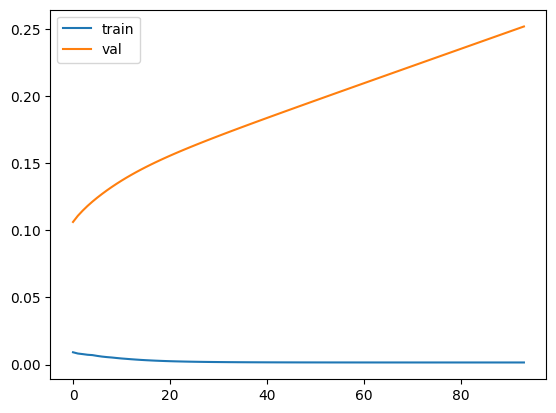

KeyboardInterrupt: 

In [160]:
# Training the simpleAE
history = []
val_history = []
test_losses = []

prev_train_loss = 1
prev_test_loss = 1
train_loss = 0.1 * len(train_dataloader)
test_loss = 0.1 * testset.userid.nunique()
epoch = 1

while prev_test_loss - test_loss / testset.userid.nunique() > 1e-4 or train_loss / len(train_dataloader) > 0.0011:
    if epoch > 1:
        prev_train_loss = train_loss / len(train_dataloader)
        prev_test_loss = test_loss / testset.userid.nunique()
    train_loss = 0
    for user_matrix in train_dataloader:
        optimizer.zero_grad()
        
        input_tensor, target = user_matrix
        input_tensor, target = input_tensor.to_dense().to(device), target.to_dense().to(device)
        
        output = bae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        
    scheduler.step()
    history.append(train_loss / len(train_dataloader))
        
#     print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))
    with torch.no_grad():
        for user in testset.userid.unique():
            itemidx = testset.loc[testset.userid == user, data_description['items']].values
            values = np.ones(len(itemidx), dtype=np.float32)

            user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
            target = user_tensor_test.clone()

            output = bae(user_tensor_test)
            target.require_grad = False

            loss = criterion(output, target)
            test_loss += loss.data.item()

        test_losses.append(test_loss / testset.userid.nunique())
    
    val_history.append(test_loss / testset.userid.nunique())
#         print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    clear_output()
    print('Epoch', epoch)
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    epoch += 1

In [161]:
scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))
for i, user in enumerate(testset.userid.unique()):
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], ))).to_dense().unsqueeze(0).to(device)
    
    output = bae(user_matrix_test)
    scores[i] = output[0].T

        
scores = scores.detach().numpy()

C:\Users\Liza\AppData\Local\Temp\ipykernel_20128\2243924272.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  scores[i] = output[0].T


In [162]:
# base
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

,HR@5,MRR@5,Coverage@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,Matthews@5
5,0.053477,0.029951,0.270644,0.050009,0.003468,0.028074,0.001877,0.026883


,HR@10,MRR@10,Coverage@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,Matthews@10
10,0.079029,0.03336,0.356552,0.074101,0.004928,0.031292,0.002068,0.035579


,HR@20,MRR@20,Coverage@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,Matthews@20
20,0.112794,0.035684,0.462851,0.106954,0.00584,0.03355,0.002134,0.055958


(0.03335998632585601, 0.07902901989414127, 0.03557897800930347)